This notebook runs a defined pipeline on HCP subjects, on the Cedars-Sinai cluster.
After it is done preprocessing all subjects, it runs the leave-one-family-out personality prediction.

# Load libraries & helper functions

In [1]:
from helpers import *
%matplotlib inline

# Declare parameters

In [2]:
config.DATADIR                 = '/scratch/duboisjx/data/HCP/MRI'
# fMRI runs
session                        = 'REST1'
fmriRuns                       = ['rfMRI_'+session+'_LR','rfMRI_'+session+'_RL']
# use volume or surface data
# config.fmriFileTemplate        = '#fMRIrun#.nii.gz'
#config.fmriFileTemplate        = '#fMRIrun#_Atlas.dtseries.nii'
config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
config.melodicFolder           = op.join('#fMRIrun#_hp2000.ica','filtered_func_data.ica') #the code #fMRIrun# will be replaced
config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'
# parcellation for FC matrix
config.parcellationName        = 'Glasser'
config.parcellationFile        = '/scratch/duboisjx/data/parcellations/Glasser2016/Parcels.dlabel.nii'
config.nParcels                = 360
config.maskParcelswithAll      = True
config.maskParcelswithGM       = False
# subject selection parameters
config.behavFile               = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
config.RbehavFile              = '/scratch/duboisjx/data/HCP/neuropsych/RESTRICTED_luckydjuju_8_22_2017_11_13_18.csv'

config.release                 = 'all'
config.outScore                = 'PMAT24_A_CR'
# submit jobs with sge
config.queue        = True

# do not alter the following lines
if config.maskParcelswithGM:
    config.parcellationName = config.parcellationName + '_GM'
tmp = config.fmriFileTemplate.split('.')
if tmp[1]=='nii':
    config.isCifti = False
elif tmp[1]=='dtseries':
    config.isCifti = True
else:
    print 'unknown file extension'

config.preWhitening            = False

# whether to use memmapping (which involves unzipping)
# deprecated
config.useMemMap               = False


# Subject selection

In [3]:
Udf = pd.read_csv(config.behavFile)
Rdf = pd.read_csv(config.RbehavFile)
# merge unrestricted and restricted
df = pd.merge(Udf,Rdf,how='inner')

# keep only variables of interest
df = df[['Subject','Release','Gender','Family_ID','Father_ID','Mother_ID','Age_in_Yrs','FS_BrainSeg_Vol','fMRI_3T_ReconVrs',
        '3T_RS-fMRI_PctCompl','PMAT_Compl','NEO-FFI_Compl','MMSE_Compl',
        'PMAT24_A_CR','MMSE_Score','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        'PicSeq_Unadj','CardSort_Unadj','Flanker_Unadj','ReadEng_Unadj',
        'ProcSpeed_Unadj','DDisc_AUC_200','DDisc_AUC_40K','VSPLOT_TC','SCPT_SEN','SCPT_SPEC',
        'IWRD_TOT','ListSort_Unadj','PicVocab_Unadj','ER40_CR','AngAffect_Unadj',
        'AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj','FearSomat_Unadj','Sadness_Unadj',
        'LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
        'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj',
        'PercStress_Unadj','SelfEff_Unadj']]

# select subjects according to release
if config.release == 'Q2':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    keepSub = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    keepSub = (df['Release'] == 'S900')
elif config.release == 'S1200':
    keepSub = (df['Release'] == 'S1200')
elif config.release == 'all':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
elif config.release == 'all+MEG2':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200') 
           | (df['Release'] == 'MEG2'))
else:
    sys.exit("Invalid release code")
print 'Selected {} subjects for release {}'.format(np.sum(keepSub),config.release)

# select subjects that have completed all fMRI
keepSub = keepSub & (
    (df['3T_RS-fMRI_PctCompl']==100) & 
    (df['PMAT_Compl']==True) &
    (df['NEO-FFI_Compl']==True)&
    (df['MMSE_Compl']==True))
print 'Kept {} subjects with complete datasets'.format(np.sum(keepSub))

# check if either of the two subjects recommended for exclusion by HCP are still present
keepSub = keepSub & (
    ~df['Subject'].isin([209733,528446]))

# remove subject missing item scores for NEO
keepSub = keepSub & (
    ~df['Subject'].isin([131924]))

# FURTHER EXCLUSIONARY CRITERIA
# --> MMSE <26 excluded
keepSub    = np.logical_and(keepSub,df['MMSE_Score']>=26)
print 'Kept {} subjects after MMSE<26 exclusion criterion'.format(np.sum(keepSub))

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
RelRMSMean = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
FDsum      = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
keepSub    = np.zeros((len(df['Subject'])),dtype=np.bool_)
iSub=0
excluded = list()
for subject in df['Subject']:
    config.subject=str(subject)
    # RelRMSMean
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            excluded.append(config.subject)
            #print RelRMSMeanFile+' File missing'
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            excluded.append(config.subject)
        else:
            keepSub[iSub]=True
    # total framewise displacement
    i=0
    for config.fmriRun in fmriRuns:
        FDsumFile = op.join(buildpath(), 'FD_sum.txt')
        if not op.isfile(FDsumFile):
            motionFile = op.join(buildpath(), config.movementRegressorsFile)
            if op.isfile(motionFile):
                dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
                headradius=50 #50mm as in Powers et al. 2012
                disp=dmotpars.copy()
                disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
                thisFDsum=np.sum(np.sum(disp,1),0)
                with open(FDsumFile,'w') as tmp:
                    tmp.write(str(thisFDsum))
            else:
                break
        with open(FDsumFile,'r') as tmp:
            FDsum[iSub,i] = float(tmp.read())
        i=i+1
    iSub=iSub+1

# add RelRMSMean and FDsum to the dataframe
df['RelRMSMean'] = np.mean(RelRMSMean,axis=1)
df['FDsum']      = np.mean(FDsum,axis=1)

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

print 'Keeping {} subjects [{} M] after excluding high motion'.format(len(df['Subject']),sum([g=='M' for g in df['Gender']]))
print 'Age range is', np.min(df['Age_in_Yrs']), '-', np.max(df['Age_in_Yrs'])

# replace labeled columns with dummies
df['Gender'].replace(['F','M'],[1,2],inplace=True)
df['fMRI_3T_ReconVrs'].replace(['r177','r177 r227','r227'],[1,2,3],inplace=True)

Selected 1191 subjects for release all
Kept 984 subjects with complete datasets
Kept 982 subjects after MMSE<26 exclusion criterion
Keeping 910 subjects [429 M] after excluding high motion
Age range is 22 - 37


In [4]:
# RECOMPUTE NEO FACTORS from items
# and Compute Cronbach's Alpha
def CronbachAlpha(itemScores):
    itemVars   = itemScores.var(axis=1, ddof=1)
    totScores  = itemScores.sum(axis=0)
    nItems     = itemScores.shape[0]
    return nItems / (nItems-1.) * (1 - itemVars.sum() / totScores.var(ddof=1))
# make copies of relevant variables
NEO = df[['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        ]].copy()
Calphas  = list();CalphasM = list();CalphasF = list();diff     = list()

# scoring = [ 
#     # O = (13, 23*, 43 // 48*, 53, 58 // 3*, 8*, 18*, 38*)
#     {'13':'n', '23':'r', '43':'n', #aesthetic interests
#    '48':'r', '53':'n', '58':'n', #intellectual interests
#    '03':'r', '08':'r', '18':'r', '38':'r'}, # unconventionality
#     # C = (5, 10, 15*, 30*, 55* // 25, 35, 60 // 20, 40, 45*, 50)
#     {'05':'n', '10':'n', '15':'r', '30':'r', '55':'r', # orderliness
#    '25':'n', '35':'n', '60':'n', # goal-striving
#    '20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
#     # E = (7, 12*, 37, 42* // 2, 17, 27*, 57* // 22, 32, 47, 52)
#     {'07':'n', '12':'r', '37':'n', '42':'r', # positive affect
#    '02':'n', '17':'n', '27':'r', '57':'r', # sociability
#    '22':'n', '32':'n', '47':'n', '52':'n'}, # activity
#     # A = (9*, 14*, 19, 24*, 29*, 44*, 54*, 59* // 4, 34, 39*, 49)
#     {'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r', #nonantagonistic orientation
#    '04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
#     # N = (1*, 11, 16*, 31*, 46* // 6, 21, 26, 36, 41, 51, 56)
#     {'01':'r', '11':'n', '16':'r', '31':'r', '46':'r', # negative affect
#    '06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
#     ]

scoring = [ 
    {'13':'n', '23':'r', '43':'n', #aesthetic interests
    '48':'r', '53':'n', '58':'n', #intellectual interests
    '03':'r', '08':'r', '18':'r', '38':'r', # unconventionality
    '28':'n', '33':'r'},#??
    {'05':'n', '10':'n', '15':'r', '30':'r', '55':'r', # orderliness
    '25':'n', '35':'n', '60':'n', # goal-striving
    '20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
    {'07':'n', '12':'r', '37':'n', '42':'r', # positive affect
   '02':'n', '17':'n', '27':'r', '57':'r', # sociability
   '22':'n', '32':'n', '47':'n', '52':'n'}, # activity
    {'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r', #nonantagonistic orientation
   '04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
    {'01':'r', '11':'n', '16':'r', '31':'r', '46':'r', # negative affect
   '06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
    ]

factors = ['O','C','E','A','N']
for iFac,factor in enumerate(factors):
    this       = np.zeros(df.shape[0])
    itemScores = np.zeros((len(scoring[iFac].keys()),df.shape[0]))
    keyCtr = -1
    for key in scoring[iFac].keys():
        if scoring[iFac][key]=='n':
            NEO['NEORAW_'+key].replace(['SD','D','N','A','SA'],[0,1,2,3,4],inplace=True)
        else:
            NEO['NEORAW_'+key].replace(['SD','D','N','A','SA'],[4,3,2,1,0],inplace=True)
        this = this + NEO['NEORAW_'+key]
        keyCtr += 1
        itemScores[keyCtr,:] = np.ravel(NEO['NEORAW_'+key])
    df['NEOFAC_'+factor+'_calc']=this
    Calphas.append(CronbachAlpha(itemScores))
    CalphasF.append(CronbachAlpha(itemScores[:,np.ravel(df['Gender']==1)]))
    CalphasM.append(CronbachAlpha(itemScores[:,np.ravel(df['Gender']==2)]))
    diff.append(np.sum(np.abs(df['NEOFAC_'+factor]-df['NEOFAC_'+factor+'_calc'])))

print 'diffO={0:d}, diffC={1:d}, diffE={2:d}, diffA={3:d}, diffN={4:d}'.format(
    np.int(diff[0]),np.int(diff[1]),np.int(diff[2]),np.int(diff[3]),np.int(diff[4]))
print 'Cronbach''s alpha   O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    Calphas[0],Calphas[1],Calphas[2],Calphas[3],Calphas[4])
print 'Cronbach''s alpha M O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    CalphasM[0],CalphasM[1],CalphasM[2],CalphasM[3],CalphasM[4])
print 'Cronbach''s alpha F O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    CalphasF[0],CalphasF[1],CalphasF[2],CalphasF[3],CalphasF[4])

# # correct scores
df['NEOFAC_A_corr'] = df['NEOFAC_A_calc']

diffO=0, diffC=0, diffE=0, diffA=2028, diffN=0
Cronbachs alpha   O=0.754, C=0.814, E=0.779, A=0.759, N=0.844
Cronbachs alpha M O=0.758, C=0.808, E=0.780, A=0.754, N=0.863
Cronbachs alpha F O=0.755, C=0.818, E=0.782, A=0.740, N=0.824


## Yanting's outlier detection (NOT USED YET)

(907, 34)
     NEOFAC_O  NEOFAC_C  NEOFAC_E  NEOFAC_A_corr  NEOFAC_N
86   1.733834  2.945794  3.141918       0.272055  0.207174
99   2.392261  3.195992  0.484035       1.116316  0.696630
102  2.816972  2.324517  0.514708       1.407007  1.681768
593  3.541178  0.591353  0.180074       2.717400  1.982242
633  2.306133  2.381088  0.833645       0.894260  0.053100
728  2.088288  2.628864  1.546122       3.087614  3.538702
771  2.674901  0.657502  0.127301       3.049172  2.031139
814  0.086207  2.523911  2.051702       2.607405  2.379803
865  1.598132  4.123526  0.466269       0.151564  3.581920


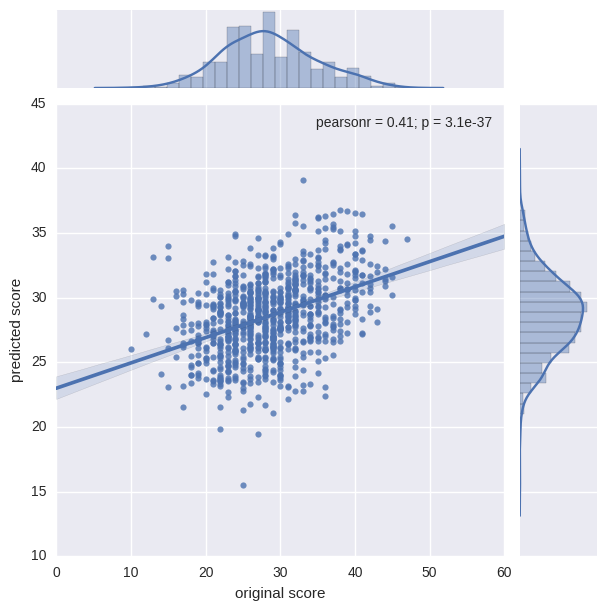

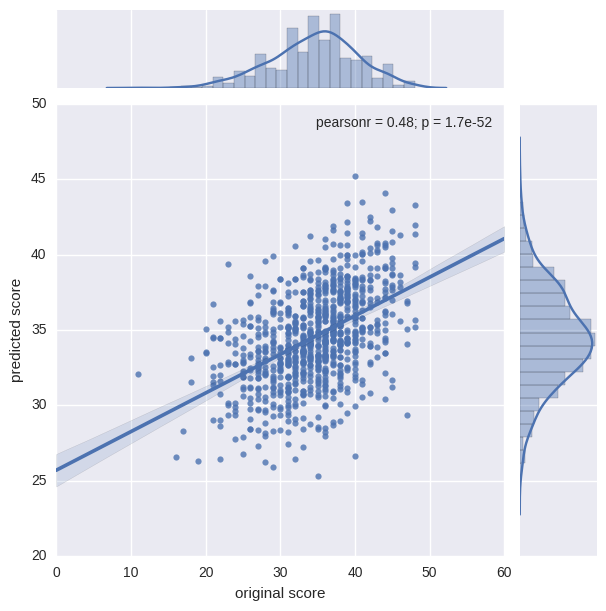

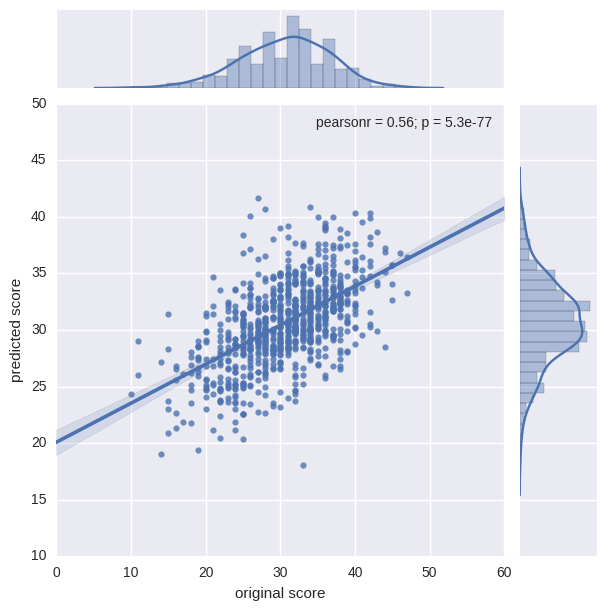

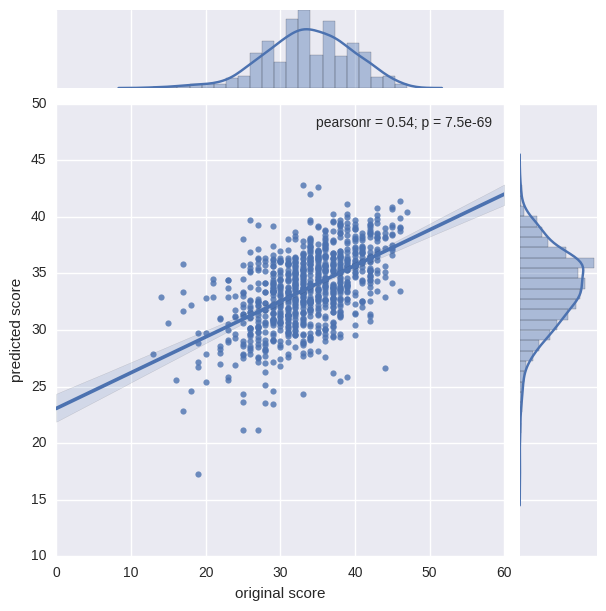

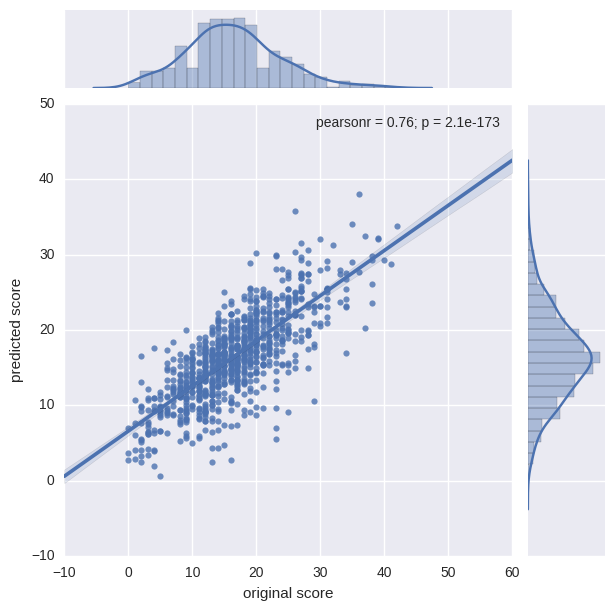

In [5]:
detectOutliers = False

# all measures under cognition & emotion category 
# described in HCP docu are used as predictors
# note that not all variables of those measures are used
predictors = ['Gender','Age_in_Yrs',
              'PicSeq_Unadj','CardSort_Unadj','Flanker_Unadj','PMAT24_A_CR','ReadEng_Unadj',
              'ProcSpeed_Unadj','DDisc_AUC_200','DDisc_AUC_40K','VSPLOT_TC','SCPT_SEN','SCPT_SPEC',
              'IWRD_TOT','ListSort_Unadj','PicVocab_Unadj','ER40_CR','AngAffect_Unadj',
              'AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj','FearSomat_Unadj','Sadness_Unadj',
              'LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
              'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj',
              'PercStress_Unadj','SelfEff_Unadj']
# last line newly added
targets = ['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']


# get index for all missing value
predictors_missed_index = []
predictors_missed_index = np.array(predictors_missed_index).reshape(0,1)
for i in range(len(predictors)):
    measure = predictors[i]
    m       = np.argwhere(np.isnan(df[measure]))
    #print measure, m.T
    predictors_missed_index = np.concatenate((m,predictors_missed_index),0)
predictors_missed_index = np.unique(predictors_missed_index)
predictors_missed_index.tolist()

n_subs = df.shape[0] - len(predictors_missed_index)

# delete missing values
newdf        = df[np.logical_not(df.index.isin(predictors_missed_index))]
newdf.index  = range(newdf.shape[0])

# make predictor matrix
X = np.zeros((n_subs,len(predictors)))
for i in range(len(predictors)):
    X[:,i] = newdf[predictors[i]]
print X.shape

# CROSS VALIDATED PREDICTION
# RESPECTING FAMILY STRUCTURE
dic_errors     = dict()
for target in targets:
    score = np.ravel(newdf[target])

    score_pred = np.empty(score.shape)
    for el in np.unique(newdf['Family_ID']):
        test_index  = list(newdf.ix[newdf['Family_ID']==el].index)
        train_index = np.setdiff1d(np.arange(n_subs),test_index)
        rbX         = RobustScaler()
        X_train     = rbX.fit_transform(X[train_index,:])
        X_test      = rbX.transform(X[test_index,:])
        X_train     = X[train_index,:]
        X_test      = X[test_index,:]
        regr        = linear_model.LinearRegression()
        regr.fit(X_train, score[train_index])
        score_pred.flat[test_index] = regr.predict(X_test)

    sns.jointplot(score,score_pred, kind="reg").set_axis_labels("original score", "predicted score")
    
    dic_errors[target] = score - score_pred

df_errors = pd.DataFrame(dic_errors, columns=targets)
    
df_errors_absZ = df_errors.apply(stats.zscore).apply(np.abs)

# COMPUTE OUTLIER SCORE
stdThr = 2.3
outlierScore = np.zeros(score.shape)
for target in targets:
    outlierScore = outlierScore + (np.ravel(df_errors_absZ[target])>stdThr)*1

# IDENTIFY OUTLIERS
outlierScoreThr = 2
print df_errors_absZ[outlierScore>=outlierScoreThr]

if detectOutliers:
    # UPDATE DATAFRAME
    # remove subjects with missing values for any of the variables used as predictors
    df = df[np.logical_not(df.index.isin(predictors_missed_index))]
    df.index  = range(df.shape[0])
    # add a column
    df['outlierScore']=outlierScore
    # remove subjects with outlier predictions
    df = df[np.logical_not(df.index.isin(np.argwhere(outlierScore>=outlierScoreThr)))]
    df.index  = range(df.shape[0])
    np.unique(df['outlierScore'])

# Do work

### preprocess everybody

In [6]:
config.overwrite               = False
config.pipelineName            = 'SiegelB'
config.Operations              = config.operationDict[config.pipelineName]
if config.pipelineName in ['SiegelA','SiegelB']:
    config.useFIX              = True
else:
    config.useFIX              = False
    
config.scriptlist = list()
keepSub = np.zeros((len(df['Subject'])),dtype=np.bool_)
iSub    = 0
for subject in df['Subject']:
    config.subject = str(subject)
    iRun = 0
    for config.fmriRun in fmriRuns:
        keepSub[iSub] = runPipelinePar(launchSubproc=False)
        if not keepSub[iSub]:
            break
        iRun=iRun+1
    iSub = iSub + 1
print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(df['Subject']))

# prune and reindex
df        = df[keepSub]
df.index  = range(df.shape[0])

# launch array job (if there is something to do)
if len(config.scriptlist)>0:
    if len(config.scriptlist)<10:
        print config.scriptlist
    config.sgeopts      = '-l mem_free=25G -pe smp 6' 
    JobID = fnSubmitJobArrayFromJobList()
    print 'Running array job {} ({} sub jobs)'.format(JobID.split('.')[0],JobID.split('.')[1].split('-')[1].split(':')[0])
    config.joblist.append(JobID.split('.')[0])
    checkProgress(pause=60,verbose=False)

Keeping 910/910 subjects


### run prediction in entire subject pool

In [7]:
# print the list of subjects to a txt file for reference
outFile = op.join(config.DATADIR,'Results','subjectList{}_{}.txt'.format(len(df['Subject']),session));
np.savetxt(outFile, df['Subject'])

#----------------------
# prepare
#----------------------
config.queue        = True
config.sgeopts      = '-l mem_free=25G -pe smp 6' 
config.overwrite    = False
config.fmriFile_dn  = ''

# make new dataframe
idx_smpl    = np.where(np.ravel(df['Release'].isin(['Q1','Q2','Q3','S500','S900','S1200','MEG2'])))[0]
newdf       = df.ix[idx_smpl].copy()
newdf.index = range(newdf.shape[0])

# output directory
outDir              = op.join(config.DATADIR,'Results','samples_nsub{}_{}'.format(newdf.shape[0],0))
if not op.isdir(outDir):
    mkdir(outDir)
# dump dataframe to file
dataFile    = op.join(outDir,'df_{}_{}_{}_{}.csv'.format(
    session,config.pipelineName, config.parcellationName, config.release))
newdf.to_csv(dataFile, sep=',', encoding='utf-8')    
# save fcMats    
fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
    session,config.pipelineName, config.parcellationName, config.release))
overwrite = False
if not op.isfile(fcMatFile) or overwrite:
    fcMats_dn = np.zeros((config.nParcels,config.nParcels,newdf.shape[0],len(fmriRuns)),dtype=np.float32)
    iSub= 0
    for subject in newdf['Subject']:
        config.subject = str(subject)
        iRun = 0
        for config.fmriRun in fmriRuns:
            # set the global variable config
            runPipelinePar(launchSubproc=False)
            #print 'Found denoised data: {}'.format(config.fmriFile_dn)
            tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
            rstring = get_rcode(config.fmriFile_dn)
            fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
            fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
            iRun = iRun+1
        iSub = iSub + 1
    fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
    results = {}
    results['fcMats']        = fcMats_dn
    results['subjects']      = np.str(newdf['Subject'])
    #results[config.outScore] = np.asarray(smpl_score)
    sio.savemat(fcMatFile, results)
fcMats_dn = sio.loadmat(fcMatFile)['fcMats']

#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False

print ('{},nsub{},{},{}'.format(
    config.release,newdf.shape[0],config.pipelineName,config.parcellationName))

# run the prediction for each subject
for model in ['Finn','elnet']:#,'svm', 'mlr','lasso', 'elnet']:
    print '> '+ model
    for decon in ['megatrawlDecon+IQ','megatrawlDecon','noDecon']:
        print '----> '+ decon
        idcode     = session+'-'+decon
        for SM in ['PMAT24_A_CR','NEOFAC_A_corr','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']: #
            if (SM=='PMAT24_A_CR') and (decon=='megatrawlDecon+IQ'):
                continue
            print '--------> '+ SM
            resFile = op.join(outDir,'{}_{}_{}_{}_{}_{}.mat'.format(
                SM,config.pipelineName,config.parcellationName, idcode, model, config.release))
            if not op.isfile(resFile) or config.overwrite:
                if decon == 'megatrawlDecon':
                    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                elif decon == 'megatrawlDecon+IQ':
                    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                elif decon == 'noDecon':
                    confounds=[]
                # run this thrice, just in case some jobs fail -- it happens
                for rep in range(3):
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,idcode=idcode,outDir=outDir,
                                    confounds=confounds)
                    checkProgress(pause=10,verbose=False)
                    sleep(10)
                # merge cross-validation folds, save results
                predictions_posneg = np.zeros([newdf.shape[0],1])
                predictions_pos    = np.zeros([newdf.shape[0],1])
                predictions_neg    = np.zeros([newdf.shape[0],1])
                for el in np.unique(newdf['Family_ID']):
                    test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                    test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                    cvResFile = op.join(outDir, '{}_{}_{}_{}_{}_{}_{}.mat'.format(SM, config.pipelineName, config.parcellationName, 
                        '_'.join(['%s' % test_sub for test_sub in test_subjects]),idcode, model,config.release))
                    results = sio.loadmat(cvResFile) 
                    if model=='Finn':
                        predictions_posneg[test_index] = results['pred_posneg'].T
                        predictions_pos[test_index]    = results['pred_pos'].T
                        predictions_neg[test_index]    = results['pred_neg'].T
                    else:
                        predictions_pos[test_index] = results['pred'].T

                if model=='Finn':
                    rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.squeeze(np.ravel(newdf[SM])))
                    rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                    rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[SM])))
                    results = {'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                            'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                            'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                else:
                    rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                    results = {'pred':predictions_pos, 'rho':rho, 'p': p}

                # save result
                sio.savemat(resFile,results)

            while not op.isfile(resFile):
                sleep(.1)
            results = sio.loadmat(resFile)

            if model=='Finn':
                print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                    results['rho_posneg'][0][0],results['p_posneg'][0][0],
                    results['rho_pos'][0][0],results['p_pos'][0][0],
                    results['rho_neg'][0][0],results['p_neg'][0][0])
                      )
            else:
                print ('rho={0:.3f},p={1:.5f}'.format(
                    results['rho'][0][0],results['p'][0][0])
                      )

/hpc/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in arctanh


all,nsub910,SiegelB,Glasser
> Finn
----> megatrawlDecon+IQ
--------> NEOFAC_A_corr
posneg,rho=0.039,p=0.24144,[pos,rho=-0.034,p=0.30267;neg,rho=0.073,p=0.02859]
--------> NEOFAC_O
posneg,rho=0.117,p=0.00041,[pos,rho=0.109,p=0.00094;neg,rho=0.018,p=0.58079]
--------> NEOFAC_C
posneg,rho=-0.044,p=0.18291,[pos,rho=-0.141,p=0.00002;neg,rho=0.089,p=0.00693]
--------> NEOFAC_N
posneg,rho=0.011,p=0.73726,[pos,rho=0.006,p=0.84974;neg,rho=-0.007,p=0.82244]
--------> NEOFAC_E
posneg,rho=0.119,p=0.00031,[pos,rho=0.065,p=0.05162;neg,rho=0.056,p=0.09420]
----> megatrawlDecon
--------> PMAT24_A_CR
posneg,rho=0.190,p=0.00000,[pos,rho=0.127,p=0.00012;neg,rho=0.051,p=0.12372]
--------> NEOFAC_A_corr
posneg,rho=0.051,p=0.12263,[pos,rho=-0.017,p=0.60073;neg,rho=0.067,p=0.04394]
--------> NEOFAC_O
posneg,rho=0.123,p=0.00020,[pos,rho=0.102,p=0.00217;neg,rho=0.029,p=0.37669]
--------> NEOFAC_C
posneg,rho=-0.049,p=0.14341,[pos,rho=-0.150,p=0.00001;neg,rho=0.092,p=0.00549]
--------> NEOFAC_N
posneg,rho=0.048,

KeyboardInterrupt: 

### GENDER

In [ ]:
#----------------------
# prepare
#----------------------
config.queue        = True
config.sgeopts      = '-l mem_free=25G -pe smp 6' 
config.overwrite    = False
config.fmriFile_dn  = ''

# make new dataframe
idx_smpl    = np.where(np.ravel(df['Gender'].isin([1])))[0]
newdf       = df.ix[idx_smpl].copy()
newdf.index = range(newdf.shape[0])

# output directory
outDir              = op.join(config.DATADIR,'Results','samples_nsub{}_Female'.format(newdf.shape[0],0))
if not op.isdir(outDir):
    mkdir(outDir)
# dump dataframe to file
dataFile    = op.join(outDir,'df_{}_{}_{}_{}.csv'.format(
    session,config.pipelineName, config.parcellationName, config.release))
newdf.to_csv(dataFile, sep=',', encoding='utf-8')    
# save fcMats    
fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
    session,config.pipelineName, config.parcellationName, config.release))
overwrite = False
if not op.isfile(fcMatFile) or overwrite:
    fcMats_dn = np.zeros((config.nParcels,config.nParcels,newdf.shape[0],len(fmriRuns)),dtype=np.float32)
    iSub= 0
    for subject in newdf['Subject']:
        config.subject = str(subject)
        iRun = 0
        for config.fmriRun in fmriRuns:
            # set the global variable config
            runPipelinePar(launchSubproc=False)
            #print 'Found denoised data: {}'.format(config.fmriFile_dn)
            tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
            rstring = get_rcode(config.fmriFile_dn)
            fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
            fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
            iRun = iRun+1
        iSub = iSub + 1
    fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
    results = {}
    results['fcMats']        = fcMats_dn
    results['subjects']      = np.str(newdf['Subject'])
    #results[config.outScore] = np.asarray(smpl_score)
    sio.savemat(fcMatFile, results)
fcMats_dn = sio.loadmat(fcMatFile)['fcMats']

#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False

print ('{},nsub{}_Female,{},{}'.format(
    config.release,newdf.shape[0],config.pipelineName,config.parcellationName))
                
# run the prediction for each subject
for model in ['elnet']:#['Finn','svm']:#, 'mlr','lasso', 'elnet']:
    print '> '+ model
    for decon in ['noDecon','megatrawlDecon','megatrawlDecon+IQ']:
        print '----> '+ decon
        idcode     = session+'-'+decon
        for SM in ['PMAT24_A_CR','NEOFAC_A_corr','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']: #
            print '--------> '+ SM
            resFile = op.join(outDir,'{}_{}_{}_{}_{}_{}.mat'.format(
                SM,config.pipelineName,config.parcellationName, idcode, model, config.release))
            if not op.isfile(resFile) or config.overwrite:
                if decon == 'megatrawlDecon':
                    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                elif decon == 'megatrawlDecon+IQ':
                    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                elif decon == 'noDecon':
                    confounds=[]
                # run this thrice, just in case some jobs fail -- it happens
                for rep in range(3):
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,idcode=idcode,outDir=outDir,
                                    confounds=confounds)
                    checkProgress(pause=10,verbose=False)
                    sleep(10)
                # merge cross-validation folds, save results
                predictions_posneg = np.zeros([newdf.shape[0],1])
                predictions_pos    = np.zeros([newdf.shape[0],1])
                predictions_neg    = np.zeros([newdf.shape[0],1])
                for el in np.unique(newdf['Family_ID']):
                    test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                    test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                    cvResFile = op.join(outDir, '{}_{}_{}_{}_{}_{}_{}.mat'.format(SM, config.pipelineName, config.parcellationName, 
                        '_'.join(['%s' % test_sub for test_sub in test_subjects]),idcode, model,config.release))
                    results = sio.loadmat(cvResFile) 
                    if model=='Finn':
                        predictions_posneg[test_index] = results['pred_posneg'].T
                        predictions_pos[test_index]    = results['pred_pos'].T
                        predictions_neg[test_index]    = results['pred_neg'].T
                    else:
                        predictions_pos[test_index] = results['pred'].T

                if model=='Finn':
                    rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.squeeze(np.ravel(newdf[SM])))
                    rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                    rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[SM])))
                    results = {'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                            'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                            'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                else:
                    rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                    results = {'pred':predictions_pos, 'rho':rho, 'p': p}

                # save result
                sio.savemat(resFile,results)

            while not op.isfile(resFile):
                sleep(.1)
            results = sio.loadmat(resFile)

            if model=='Finn':
                print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                    results['rho_posneg'][0][0],results['p_posneg'][0][0],
                    results['rho_pos'][0][0],results['p_pos'][0][0],
                    results['rho_neg'][0][0],results['p_neg'][0][0])
                      )
            else:
                print ('rho={0:.3f},p={1:.5f}'.format(
                    results['rho'][0][0],results['p'][0][0])
                      )

In [ ]:
#----------------------
# prepare
#----------------------
config.queue        = True
config.sgeopts      = '-l mem_free=25G -pe smp 6' 
config.overwrite    = False
config.fmriFile_dn  = ''

# make new dataframe
idx_smpl    = np.where(np.ravel(df['Gender'].isin([2])))[0]
newdf       = df.ix[idx_smpl].copy()
newdf.index = range(newdf.shape[0])

# output directory
outDir              = op.join(config.DATADIR,'Results','samples_nsub{}_Male'.format(newdf.shape[0],0))
if not op.isdir(outDir):
    mkdir(outDir)
# dump dataframe to file
dataFile    = op.join(outDir,'df_{}_{}_{}_{}.csv'.format(
    session,config.pipelineName, config.parcellationName, config.release))
newdf.to_csv(dataFile, sep=',', encoding='utf-8')    
# save fcMats    
fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
    session,config.pipelineName, config.parcellationName, config.release))
overwrite = False
if not op.isfile(fcMatFile) or overwrite:
    fcMats_dn = np.zeros((config.nParcels,config.nParcels,newdf.shape[0],len(fmriRuns)),dtype=np.float32)
    iSub= 0
    for subject in newdf['Subject']:
        config.subject = str(subject)
        iRun = 0
        for config.fmriRun in fmriRuns:
            # set the global variable config
            runPipelinePar(launchSubproc=False)
            #print 'Found denoised data: {}'.format(config.fmriFile_dn)
            tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
            rstring = get_rcode(config.fmriFile_dn)
            fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
            fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
            iRun = iRun+1
        iSub = iSub + 1
    fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
    results = {}
    results['fcMats']        = fcMats_dn
    results['subjects']      = np.str(newdf['Subject'])
    #results[config.outScore] = np.asarray(smpl_score)
    sio.savemat(fcMatFile, results)
fcMats_dn = sio.loadmat(fcMatFile)['fcMats']

#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False

print ('{},nsub{}_Male,{},{}'.format(
    config.release,newdf.shape[0],config.pipelineName,config.parcellationName))
                
# run the prediction for each subject
for model in ['elnet']:#['Finn','svm']:#, 'mlr','lasso', 'elnet']:
    print '> '+ model
    for decon in ['noDecon','megatrawlDecon','megatrawlDecon+IQ']:
        print '----> '+ decon
        idcode     = session+'-'+decon
        for SM in ['PMAT24_A_CR','NEOFAC_A_corr','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']: #
            print '--------> '+ SM
            resFile = op.join(outDir,'{}_{}_{}_{}_{}_{}.mat'.format(
                SM,config.pipelineName,config.parcellationName, idcode, model, config.release))
            if not op.isfile(resFile) or config.overwrite:
                if decon == 'megatrawlDecon':
                    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                elif decon == 'megatrawlDecon+IQ':
                    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                elif decon == 'noDecon':
                    confounds=[]
                # run this thrice, just in case some jobs fail -- it happens
                for rep in range(3):
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,idcode=idcode,outDir=outDir,
                                    confounds=confounds)
                    checkProgress(pause=10,verbose=False)
                    sleep(10)
                # merge cross-validation folds, save results
                predictions_posneg = np.zeros([newdf.shape[0],1])
                predictions_pos    = np.zeros([newdf.shape[0],1])
                predictions_neg    = np.zeros([newdf.shape[0],1])
                for el in np.unique(newdf['Family_ID']):
                    test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                    test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                    cvResFile = op.join(outDir, '{}_{}_{}_{}_{}_{}_{}.mat'.format(SM, config.pipelineName, config.parcellationName, 
                        '_'.join(['%s' % test_sub for test_sub in test_subjects]),idcode, model,config.release))
                    results = sio.loadmat(cvResFile) 
                    if model=='Finn':
                        predictions_posneg[test_index] = results['pred_posneg'].T
                        predictions_pos[test_index]    = results['pred_pos'].T
                        predictions_neg[test_index]    = results['pred_neg'].T
                    else:
                        predictions_pos[test_index] = results['pred'].T

                if model=='Finn':
                    rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.squeeze(np.ravel(newdf[SM])))
                    rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                    rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[SM])))
                    results = {'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                            'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                            'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                else:
                    rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                    results = {'pred':predictions_pos, 'rho':rho, 'p': p}

                # save result
                sio.savemat(resFile,results)

            while not op.isfile(resFile):
                sleep(.1)
            results = sio.loadmat(resFile)

            if model=='Finn':
                print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                    results['rho_posneg'][0][0],results['p_posneg'][0][0],
                    results['rho_pos'][0][0],results['p_pos'][0][0],
                    results['rho_neg'][0][0],results['p_neg'][0][0])
                      )
            else:
                print ('rho={0:.3f},p={1:.5f}'.format(
                    results['rho'][0][0],results['p'][0][0])
                      )

### r227 recon only

In [ ]:
if False:
    #----------------------
    # prepare
    #----------------------
    config.queue        = True
    config.sgeopts      = '-l mem_free=25G -pe smp 6' 
    config.overwrite    = False
    config.fmriFile_dn  = ''

    # make new dataframe
    idx_smpl    = np.where(np.ravel(df['fMRI_3T_ReconVrs'].isin([3])))[0]
    newdf       = df.ix[idx_smpl].copy()
    newdf.index = range(newdf.shape[0])

    # output directory
    outDir              = op.join(config.DATADIR,'Results','samples_nsub{}_r227'.format(newdf.shape[0],0))
    if not op.isdir(outDir):
        mkdir(outDir)
    # dump dataframe to file
    dataFile    = op.join(outDir,'df_{}_{}_{}_{}.csv'.format(
        session,config.pipelineName, config.parcellationName, config.release))
    newdf.to_csv(dataFile, sep=',', encoding='utf-8')    
    # save fcMats    
    fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
        session,config.pipelineName, config.parcellationName, config.release))
    overwrite = False
    if not op.isfile(fcMatFile) or overwrite:
        fcMats_dn = np.zeros((config.nParcels,config.nParcels,newdf.shape[0],len(fmriRuns)),dtype=np.float32)
        iSub= 0
        for subject in newdf['Subject']:
            config.subject = str(subject)
            iRun = 0
            for config.fmriRun in fmriRuns:
                # set the global variable config
                runPipelinePar(launchSubproc=False)
                #print 'Found denoised data: {}'.format(config.fmriFile_dn)
                tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
                rstring = get_rcode(config.fmriFile_dn)
                fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
                fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
                iRun = iRun+1
            iSub = iSub + 1
        fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
        results = {}
        results['fcMats']        = fcMats_dn
        results['subjects']      = np.str(newdf['Subject'])
        #results[config.outScore] = np.asarray(smpl_score)
        sio.savemat(fcMatFile, results)
    fcMats_dn = sio.loadmat(fcMatFile)['fcMats']

    #----------------------
    # predict!
    #----------------------
    config.queue     = True
    launchSubproc    = False
    config.sgeopts   = '-l mem_free=2G' 
    config.overwrite = False

    print ('{},nsub{}_227,{},{}'.format(
        config.release,newdf.shape[0],config.pipelineName,config.parcellationName))

    # run the prediction for each subject
    for model in ['elnet']:#'Finn','svm', 'mlr','lasso', 'elnet']:
        print '> '+ model
        for decon in ['noDecon','megatrawlDecon','megatrawlDecon+IQ']:
            print '----> '+ decon
            idcode     = session+'-'+decon
            for SM in ['PMAT24_A_CR','NEOFAC_A_corr','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']: #
                print '--------> '+ SM
                resFile = op.join(outDir,'{}_{}_{}_{}_{}_{}.mat'.format(
                    SM,config.pipelineName,config.parcellationName, idcode, model, config.release))
                if not op.isfile(resFile) or config.overwrite:
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    # run this thrice, just in case some jobs fail -- it happens
                    for rep in range(3):
                        runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,idcode=idcode,outDir=outDir,
                                        confounds=confounds)
                        checkProgress(pause=10,verbose=False)
                        sleep(10)
                    # merge cross-validation folds, save results
                    predictions_posneg = np.zeros([newdf.shape[0],1])
                    predictions_pos    = np.zeros([newdf.shape[0],1])
                    predictions_neg    = np.zeros([newdf.shape[0],1])
                    for el in np.unique(newdf['Family_ID']):
                        test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                        test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                        cvResFile = op.join(outDir, '{}_{}_{}_{}_{}_{}_{}.mat'.format(SM, config.pipelineName, config.parcellationName, 
                            '_'.join(['%s' % test_sub for test_sub in test_subjects]),idcode, model,config.release))
                        results = sio.loadmat(cvResFile) 
                        if model=='Finn':
                            predictions_posneg[test_index] = results['pred_posneg'].T
                            predictions_pos[test_index]    = results['pred_pos'].T
                            predictions_neg[test_index]    = results['pred_neg'].T
                        else:
                            predictions_pos[test_index] = results['pred'].T

                    if model=='Finn':
                        rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.squeeze(np.ravel(newdf[SM])))
                        rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                        rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[SM])))
                        results = {'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                    else:
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[SM])))
                        results = {'pred':predictions_pos, 'rho':rho, 'p': p}

                    # save result
                    sio.savemat(resFile,results)

                while not op.isfile(resFile):
                    sleep(.1)
                results = sio.loadmat(resFile)

                if model=='Finn':
                    print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                        results['rho_posneg'][0][0],results['p_posneg'][0][0],
                        results['rho_pos'][0][0],results['p_pos'][0][0],
                        results['rho_neg'][0][0],results['p_neg'][0][0])
                          )
                else:
                    print ('rho={0:.3f},p={1:.5f}'.format(
                        results['rho'][0][0],results['p'][0][0])
                          )